<a href="https://colab.research.google.com/github/hvu88/IA_Fundamentals/blob/main/TSP__GA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Genetic Algorithms

# TSP problem

Plotting

In [ ]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from matplotlib import pyplot as plt
import random


def plot_tsp(nodes, route):
    """
    Plot the TSP nodes and route.

    Parameters:
    - nodes: List of tuples containing the coordinates of each node.
    - route: List of node indices representing the TSP route.
    """
    x = [node[0] for node in nodes]
    y = [node[1] for node in nodes]

    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, color='blue', zorder=2)  # Plot nodes


    for i in range(len(route) - 1):
        node1 = route[i]
        node2 = route[i + 1]
        plt.plot([nodes[node1][0], nodes[node2][0]], [nodes[node1][1], nodes[node2][1]], color='red', zorder=1)  # Plot route

    # Connect the last node to the first node to form a loop
    node1 = route[-1]
    node2 = route[0]
    #plt.plot([nodes[node1][0], nodes[node2][0]], [nodes[node1][1], nodes[node2][1]], color='red', zorder=1)  # Plot route

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('TSP Nodes and Route')
    plt.grid(True)
    plt.show()

#Population initialization
Inicialización guiada con heurística: nearest neighbor


In [ ]:
#Genera una ruta inicial usando la heurística de vecino más cercano
def nearest_neighbor(num_cities, distances):
    route = []
    visited = set()

    # Selecciona una ciudad inicial al azar
    current_city = np.random.randint(0, num_cities)
    route.append(current_city)
    visited.add(current_city)

    while len(visited) < num_cities:
        # Encuentra la ciudad no visitada más cercana
        nearest_city = None
        min_distance = float('inf')  # min_distance se inicializa con el valor infinito positivo
        for city in range(num_cities):
            if city not in visited and distances[current_city][city] < min_distance:
                nearest_city = city
                min_distance = distances[current_city][city]

        # Añade la ciudad más cercana a la ruta
        route.append(nearest_city)
        visited.add(nearest_city)
        current_city = nearest_city

    return route

# Create initial population
def create_initial_population(pop_size, N, distances):
    population = []
    while len(population) < pop_size:
        for _ in range(pop_size):
          individual = nearest_neighbor(N, distances)
          population.append(individual)
    return population


Inicialización random sin individuos duplicados.

In [ ]:
# Create initial population
def create_initial_population(pop_size, num_cities):
    population = set() # asegurar que la población no contenga ciudades repetidas
    while len(population) < pop_size:
        individual = tuple(np.random.permutation(num_cities))
        population.add(individual)
    return [list(ind) for ind in population]


Inicialización hibrida

In [ ]:
# Crear población inicial híbrida
def create_hybrid_population(pop_size, num_cities, distances):
    population = set()

    # Crear una parte de la población usando heurística (Nearest Neighbor)
    heuristic_size = int(0.4 * pop_size)  # 40% de la población
    for _ in range(heuristic_size):
        individual = nearest_neighbor(num_cities, distances)
        population.add(tuple(individual))

    # Crear el resto de la población de manera aleatoria
    random_size = pop_size - heuristic_size
    while len(population) < pop_size:
        individual = tuple(np.random.permutation(num_cities))  # Generar un individuo aleatorio
        population.add(individual)  # Agregar como tupla para evitar duplicados

    # Convertir las tuplas de vuelta a listas antes de devolver
    return [list(ind) for ind in population]

#Fitness

In [ ]:
def fitness(solution): # distancia mínima
  distance = 0
  for i in range(len(solution)-1):
    distance += distances[solution[i]][solution[i+1]]
  return distance

# Selection

Roulette Wheel Selection

In [ ]:
def roulete_wheel_selection_minimization(population, all_fitness):
    max_fitness = max(all_fitness)
    inverted_fitness = [max_fitness - f for f in all_fitness]  # invert fitness
    total_fitness = sum(inverted_fitness)
    selection_probs = [f / total_fitness for f in inverted_fitness]
    return population[np.random.choice(len(population), p=selection_probs)]

Tournament selection

In [ ]:
def tournament_selection(population, fitness_values, k=4):
    """
    Selección por torneo.
    :param population: Lista de individuos.
    :param fitness_values: Lista de fitness correspondientes.
    :param k: Tamaño del torneo.
    :return: Individuo seleccionado.
    """


    # Seleccionar k individuos al azar
    tournament_indices = random.sample(range(len(population)), k)
    tournament_individuals = [population[i] for i in tournament_indices]
    tournament_fitness = [fitness_values[i] for i in tournament_indices]

    # Seleccionar el individuo con mejor fitness en el torneo
    best_index = tournament_indices[np.argmin(tournament_fitness)]
    return population[best_index]


Rank-based selection

In [ ]:
def rank_selection(population, fitness_values):
    # Ordenar la población por fitness
    sorted_indices = np.argsort(fitness_values)  # Índices de menor a mayor fitness
    sorted_population = [population[i] for i in sorted_indices]
    sorted_fitness = [fitness_values[i] for i in sorted_indices]

    # Asignar rangos (1 para el peor, n para el mejor)
    num_individuals = len(population)
    ranks = list(range(num_individuals, 0, -1 ))  # [n,n-1,n-2, ...,1]

    # Calcular probabilidades de selección basadas en el rango
    total_ranks = sum(ranks)
    selection_probs = [rank / total_ranks for rank in ranks]  # Probabilidades proporcionales al rango

    # Seleccionar un individuo utilizando ruleta
    selected_index = np.random.choice(len(sorted_population), p=selection_probs)
    return sorted_population[selected_index]


#Crossover

Ordered crossover

In [ ]:
def fill_child(child, parent, end):
    size = len(parent)
    current_pos = (end + 1) % size
    for gene in parent:
        if gene not in child:
            child[current_pos] = gene
            current_pos = (current_pos + 1) % size

def ordered_crossover(parent1, parent2):
    size = len(parent1)
    child1, child2 = [-1]*size, [-1]*size # crea los hijos llenos de -1 al principio

    start, end = sorted(random.sample(range(size), 2))
    child1[start:end+1] = parent2[start:end+1]
    child2[start:end+1] = parent1[start:end+1]

    fill_child(child1, parent1, end)
    fill_child(child2, parent2, end)

    return child1, child2


# Mutation

Swap mutation

In [ ]:
def swap_mutate(individual):
  i, j = np.random.choice(len(individual), 2, replace=False) # two random indices
  new_individual = individual.copy()
  new_individual[i], new_individual[j] = individual[j], individual[i]
  return new_individual


#Selection elite

We will select some of the previous generation

In [ ]:
def select_elite(population, all_fitness, elite_size):   # selecciona los que tengan el menor fitness
  elite_indices = np.argsort(all_fitness)[:elite_size]
  return np.array(population)[elite_indices], elite_indices


#Integration

#Exp 1


In [ ]:
# hyperparametros
pop_size = 150
N = 100
elite_size = 20
mutation_rate = 0.001
generations = 2000

#pop_size = 300
#N = 100
#elite_size = 50
#mutation_rate = 0.01
#generations = 10_000

In [ ]:
#Ciudades y distancias
cities = np.random.rand(N, 2)
distances = squareform(pdist(cities, 'euclidean'))

print(cities)
print(distances)

[[0.11887834 0.74814481]
 [0.35242999 0.56850929]
 [0.91676028 0.73264886]
 [0.04693427 0.47319595]
 [0.66213072 0.3015361 ]
 [0.73728083 0.49215208]
 [0.95061222 0.54911887]
 [0.98934232 0.44180052]
 [0.30745249 0.77233485]
 [0.49879707 0.71153427]
 [0.69672492 0.59474543]
 [0.50222916 0.47548048]
 [0.68443784 0.5324764 ]
 [0.79455886 0.00200025]
 [0.30211538 0.52520744]
 [0.68609959 0.77416644]
 [0.76966499 0.2660686 ]
 [0.89977711 0.78583237]
 [0.87735577 0.95503449]
 [0.89977407 0.56492678]
 [0.5319357  0.41401204]
 [0.90886532 0.11054402]
 [0.14120679 0.31371159]
 [0.15610773 0.9561444 ]
 [0.25233823 0.8830536 ]
 [0.30313571 0.8265517 ]
 [0.57619165 0.35644097]
 [0.66291882 0.91065215]
 [0.74059489 0.2861996 ]
 [0.17708046 0.9992693 ]
 [0.06257719 0.77576066]
 [0.63901513 0.42829581]
 [0.69576702 0.81565429]
 [0.36094884 0.32406384]
 [0.38204158 0.85168037]
 [0.26179929 0.2874722 ]
 [0.7226038  0.03914721]
 [0.76037156 0.12256641]
 [0.48532351 0.25776928]
 [0.77898961 0.37285068]


Roulette wheel selection

Generation 0 | Best distance: 43.72748870686048
Generation 50 | Best distance: 30.678483486470675
Generation 100 | Best distance: 25.18502709984364
Generation 150 | Best distance: 22.180455920372268
Generation 200 | Best distance: 20.758436341466478
Generation 250 | Best distance: 19.526544017562525
Generation 300 | Best distance: 18.319083111753418
Generation 350 | Best distance: 17.38249409161872
Generation 400 | Best distance: 16.32725443943465
Generation 450 | Best distance: 15.526761576270303
Generation 500 | Best distance: 14.728846724308472
Generation 550 | Best distance: 14.229837767792835
Generation 600 | Best distance: 13.981359974762775
Generation 650 | Best distance: 13.648630648956194
Generation 700 | Best distance: 12.754811010556887
Generation 750 | Best distance: 12.34159501206314
Generation 800 | Best distance: 11.840661289760549
Generation 850 | Best distance: 11.684847241103137
Generation 900 | Best distance: 11.63376372837846
Generation 950 | Best distance: 11.48107

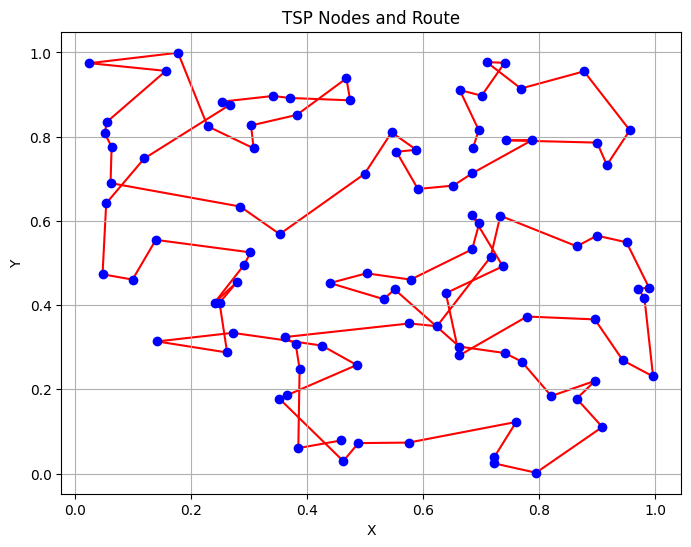

In [ ]:
history_roulette = []

# Archivo para guardar los resultados
def save_results(generation, best_route, best_distance, file_name="output.txt"):
    with open(file_name, 'a') as file:
        file.write(f"Type: Roulette | Generation {generation} | Best distance: {best_distance} | Best route: {best_route}\n")

# Genetic Algorithm
def genetic_algorithm(distance_matrix, mutation_rate, generations):
    population = create_initial_population(pop_size, N) # population size and num cities
    all_fitness = [ fitness(sol) for sol in population]

    for generation in range(generations+1):
        new_population = []

        # Preserve elite individuals
        selected_elite, elite_indices = select_elite(population, all_fitness, elite_size)
        new_population.extend(selected_elite)

        # Create new population through crossover and mutation
        while len(new_population) < pop_size:
            parent1 = roulete_wheel_selection_minimization(population, all_fitness)
            parent2 = roulete_wheel_selection_minimization(population, all_fitness)
            child1, child2 = ordered_crossover(parent1, parent2)

            if random.random() < mutation_rate:
                child1 = swap_mutate(child1)
            if random.random() < mutation_rate:
                child2 = swap_mutate(child2)

            new_population.extend([child1, child2])

        population = new_population[:pop_size] # replace with new population
        all_fitness = [ fitness(sol) for sol in population]
        if generation % 50 == 0:
          print(f"Generation {generation} | Best distance: {min(all_fitness)}")
          history_roulette.append([generation, min(all_fitness)])



    best_route_index = np.argmin(all_fitness)
    best_route = population[best_route_index]
    best_distance = all_fitness[best_route_index]
    save_results(generation-1, best_route, best_distance)  # Guardar en el archivo

    print(f"Final best distance: {best_distance}")
    return best_route, best_distance


best_route, best_distance = genetic_algorithm(distances, mutation_rate, generations)
print(best_route)
plot_tsp(cities, best_route)

Rank-based selection

Generation 0 | Best distance: 44.263827337659784
Generation 50 | Best distance: 29.597276241413578
Generation 100 | Best distance: 23.56804192909207
Generation 150 | Best distance: 20.09931448493347
Generation 200 | Best distance: 18.88180081380408
Generation 250 | Best distance: 17.670266767468934
Generation 300 | Best distance: 16.183982755017098
Generation 350 | Best distance: 14.640020959989464
Generation 400 | Best distance: 13.700910409653723
Generation 450 | Best distance: 12.75020091310919
Generation 500 | Best distance: 12.652474805362026
Generation 550 | Best distance: 12.51032245574197
Generation 600 | Best distance: 11.946470883355344
Generation 650 | Best distance: 11.829275619644113
Generation 700 | Best distance: 11.628904170694334
Generation 750 | Best distance: 11.218104212224219
Generation 800 | Best distance: 11.218104212224219
Generation 850 | Best distance: 11.218104212224219
Generation 900 | Best distance: 11.218104212224219
Generation 950 | Best distance: 11.1521

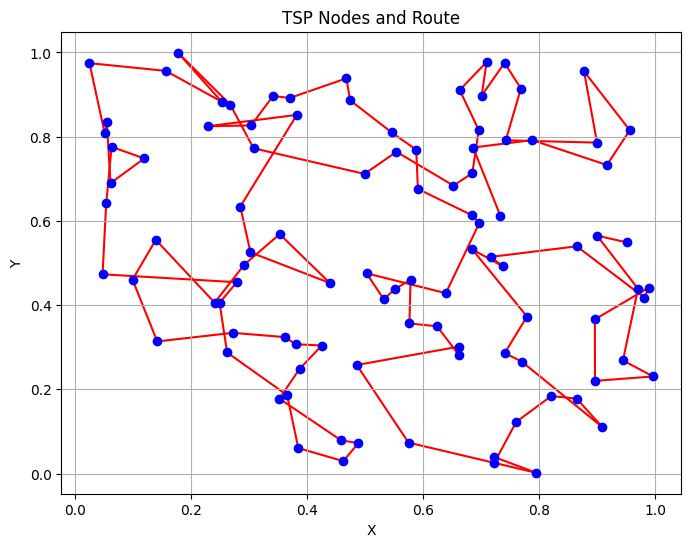

In [ ]:
history_rank = []

# Archivo para guardar los resultados
def save_results(generation, best_route, best_distance, file_name="output.txt"):
    with open(file_name, 'a') as file:
        file.write(f"Type: Rank | Generation {generation} | Best distance: {best_distance} | Best route: {best_route}\n")

# Genetic Algorithm
def genetic_algorithm(distance_matrix, mutation_rate, generations):
    population = create_initial_population(pop_size, N) # population size and num cities
    all_fitness = [ fitness(sol) for sol in population]

    for generation in range(generations+1):
        new_population = []

        # Preserve elite individuals
        selected_elite, elite_indices = select_elite(population, all_fitness, elite_size)
        new_population.extend(selected_elite)

        # Create new population through crossover and mutation
        while len(new_population) < pop_size:
            parent1 = rank_selection(population, all_fitness)
            parent2 = rank_selection(population, all_fitness)
            child1, child2 = ordered_crossover(parent1, parent2)

            if random.random() < mutation_rate:
                child1 = swap_mutate(child1)
            if random.random() < mutation_rate:
                child2 = swap_mutate(child2)

            new_population.extend([child1, child2])

        population = new_population[:pop_size] # replace with new population
        all_fitness = [ fitness(sol) for sol in population]
        if generation % 50 == 0:
          print(f"Generation {generation} | Best distance: {min(all_fitness)}")
          history_rank.append([generation, min(all_fitness)])


    best_route_index = np.argmin(all_fitness)
    best_route = population[best_route_index]
    best_distance = all_fitness[best_route_index]
    save_results(generation-1, best_route, best_distance)  # Guardar en el archivo


    print(f"Final best distance: {best_distance}")
    return best_route, best_distance

best_route, best_distance = genetic_algorithm(distances, mutation_rate, generations)
print(best_route)
plot_tsp(cities, best_route)

Tournament selection

Generation 0 | Best distance: 43.447439088788784
Generation 50 | Best distance: 23.564244413524168
Generation 100 | Best distance: 19.17939500625289
Generation 150 | Best distance: 16.419196585410457
Generation 200 | Best distance: 14.51178916172737
Generation 250 | Best distance: 13.221168999602517
Generation 300 | Best distance: 12.108514227617393
Generation 350 | Best distance: 11.806301750741913
Generation 400 | Best distance: 11.392214556269145
Generation 450 | Best distance: 11.236913627718687
Generation 500 | Best distance: 10.953896130619706
Generation 550 | Best distance: 10.683211425294822
Generation 600 | Best distance: 10.275553973176173
Generation 650 | Best distance: 10.216705076011781
Generation 700 | Best distance: 9.9695642036466
Generation 750 | Best distance: 9.9695642036466
Generation 800 | Best distance: 9.961304303706534
Generation 850 | Best distance: 9.961304303706534
Generation 900 | Best distance: 9.961304303706534
Generation 950 | Best distance: 9.94047052601

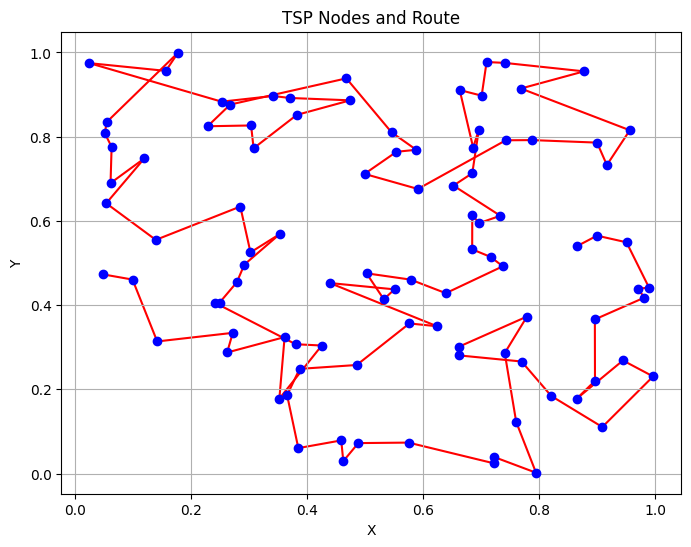

In [ ]:
history_tournament = []

# Archivo para guardar los resultados
def save_results(generation, best_route, best_distance, file_name="output.txt"):
    with open(file_name, 'a') as file:
        file.write(f"Type: Tournament | Generation {generation} | Best distance: {best_distance} | Best route: {best_route}\n")

# Genetic Algorithm
def genetic_algorithm(distance_matrix, mutation_rate, generations):
    population = create_initial_population(pop_size, N) # population size and num cities
    all_fitness = [ fitness(sol) for sol in population]

    for generation in range(generations+1):
        new_population = []

        # Preserve elite individuals
        selected_elite, elite_indices = select_elite(population, all_fitness, elite_size)
        new_population.extend(selected_elite)

        # Create new population through crossover and mutation
        while len(new_population) < pop_size:
            parent1 = tournament_selection(population, all_fitness)
            parent2 = tournament_selection(population, all_fitness)
            child1, child2 = ordered_crossover(parent1, parent2)

            if random.random() < mutation_rate:
                child1 = swap_mutate(child1)
            if random.random() < mutation_rate:
                child2 = swap_mutate(child2)

            new_population.extend([child1, child2])

        population = new_population[:pop_size] # replace with new population
        all_fitness = [ fitness(sol) for sol in population]
        if generation % 50 == 0:
          print(f"Generation {generation} | Best distance: {min(all_fitness)}")
          history_tournament.append([generation, min(all_fitness)])


    best_route_index = np.argmin(all_fitness)
    best_route = population[best_route_index]
    best_distance = all_fitness[best_route_index]
    save_results(generation-1, best_route, best_distance)  # Guardar en el archivo

    print(f"Final best distance: {best_distance}")
    return best_route, best_distance


best_route, best_distance = genetic_algorithm(distances, mutation_rate, generations)
print(best_route)
plot_tsp(cities, best_route)

Fitness scaling (Tournament selection)

Generation 0 | Best distance: 43.74970019495082
Generation 50 | Best distance: 21.546756102821313
Generation 100 | Best distance: 17.432465858610072
Generation 150 | Best distance: 15.26867106841891
Generation 200 | Best distance: 13.745451542715152
Generation 250 | Best distance: 13.537907946454435
Generation 300 | Best distance: 13.363233987048268
Generation 350 | Best distance: 12.662899154028505
Generation 400 | Best distance: 12.094609017517106
Generation 450 | Best distance: 11.402218540117099
Generation 500 | Best distance: 10.873867570953818
Generation 550 | Best distance: 10.210413845815022
Generation 600 | Best distance: 10.123233243166284
Generation 650 | Best distance: 10.123233243166284
Generation 700 | Best distance: 10.048160730384744
Generation 750 | Best distance: 10.048160730384744
Generation 800 | Best distance: 9.996788807743247
Generation 850 | Best distance: 9.740815243628191
Generation 900 | Best distance: 9.740815243628191
Generation 950 | Best distance: 9.74081

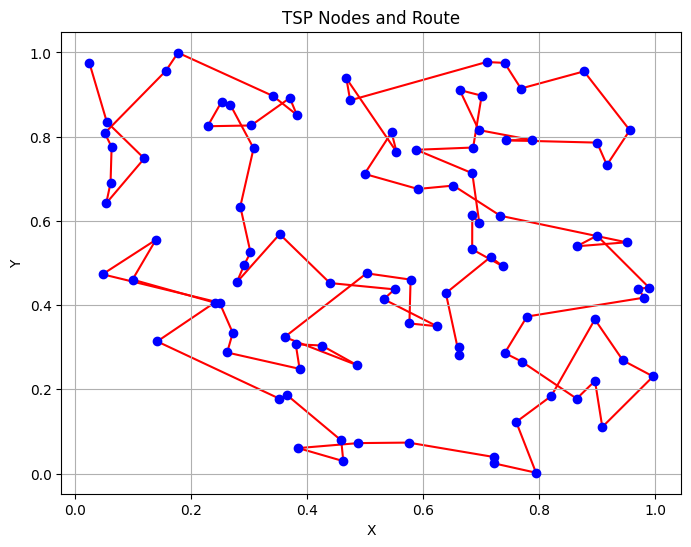

In [ ]:
history_fitness_scaling = []

# Archivo para guardar los resultados
def save_results(generation, best_route, best_distance, file_name="output.txt"):
    with open(file_name, 'a') as file:
        file.write(f"Type: Scaling | Generation {generation} | Best distance: {best_distance} | Best route: {best_route}\n")

def tournament_selection_with_scaling(population, fitness_values, k=4):
    # Aplicar fitness scaling para problemas de minimización
    max_fitness = max(fitness_values)
    scaled_fitness = [max_fitness - f for f in fitness_values]  # Invertir fitness

    # Normalizar el fitness escalado
    min_scaled_fitness = min(scaled_fitness)
    normalized_fitness = [
        f - min_scaled_fitness + 1e-6 for f in scaled_fitness
    ]  # Evitar valores cercanos a 0

    # Seleccionar k individuos al azar
    tournament_indices = random.sample(range(len(population)), k)
    tournament_individuals = [population[i] for i in tournament_indices]
    tournament_fitness = [normalized_fitness[i] for i in tournament_indices]

    # Seleccionar el individuo con mejor fitness en el torneo
    best_index = tournament_indices[np.argmax(tournament_fitness)]
    return population[best_index]

# Genetic Algorithm
def genetic_algorithm(distance_matrix, mutation_rate, generations):
    population = create_initial_population(pop_size, N) # population size and num cities
    all_fitness = [ fitness(sol) for sol in population]

    for generation in range(generations+1):
        new_population = []

        # Preserve elite individuals
        selected_elite, elite_indices = select_elite(population, all_fitness, elite_size)
        new_population.extend(selected_elite)

        # Create new population through crossover and mutation
        while len(new_population) < pop_size:
            parent1 = tournament_selection_with_scaling(population, all_fitness)
            parent2 = tournament_selection_with_scaling(population, all_fitness)
            child1, child2 = ordered_crossover(parent1, parent2)

            if random.random() < mutation_rate:
                child1 = swap_mutate(child1)
            if random.random() < mutation_rate:
                child2 = swap_mutate(child2)

            new_population.extend([child1, child2])

        population = new_population[:pop_size] # replace with new population
        all_fitness = [ fitness(sol) for sol in population]
        if generation % 50 == 0:
          print(f"Generation {generation} | Best distance: {min(all_fitness)}")
          history_fitness_scaling.append([generation, min(all_fitness)])


    best_route_index = np.argmin(all_fitness)
    best_route = population[best_route_index]
    best_distance = all_fitness[best_route_index]
    save_results(generation-1, best_route, best_distance)  # Guardar en el archivo

    print(f"Final best distance: {best_distance}")
    return best_route, best_distance

best_route, best_distance = genetic_algorithm(distances, mutation_rate, generations)
print(best_route)
plot_tsp(cities, best_route)

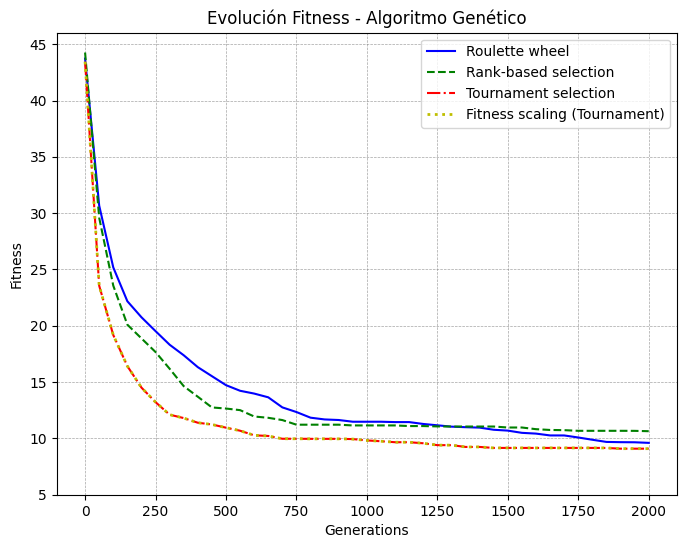

In [ ]:
from matplotlib import pyplot as plt

# Convertir los datos de cada historia a un array de NumPy
data_roulette = np.array(history_roulette)
data_rank = np.array(history_rank)
data_tournament = np.array(history_tournament)
data_tournament_scaling = np.array(history_fitness_scaling)


# Separar las columnas en x (generaciones) e y (fitness) para cada tipo de selección

plt.figure(figsize=(8, 6))

x_roulette = data_roulette[:, 0]
y_roulette = data_roulette[:, 1]

x_rank = data_rank[:, 0]
y_rank = data_rank[:, 1]

x_tournament = data_tournament[:, 0]
y_tournament = data_tournament[:, 1]

x_tournament_scaling = data_tournament[:, 0]
y_tournament_scaling = data_tournament[:, 1]

# Graficar las tres curvas
plt.plot(x_roulette, y_roulette, color='b', linestyle='-', label='Roulette wheel')
plt.plot(x_rank, y_rank, color='g', linestyle='--', label='Rank-based selection')
plt.plot(x_tournament, y_tournament, color='r', linestyle='-.', label='Tournament selection')
plt.plot(x_tournament_scaling, y_tournament_scaling, color='y', linestyle=':', linewidth=2, label='Fitness scaling (Tournament)')

# Etiquetas y título
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.title('Evolución Fitness - Algoritmo Genético')

plt.xticks(ticks=np.arange(0, 2001, 250))  # Espaciado cada 2000 generaciones
plt.yticks(ticks=np.arange(5, 50, 5))      # Espaciado más claro en el eje y

plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Leyenda
plt.legend()

# Mostrar el gráfico
plt.show()
